## Chapter 2 Generalized Linear Regression

In [4]:
import copy
import japanize_matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib.pyplot import imshow
from numpy.random import randn
from scipy import stats

C:\Users\prof-\anaconda3\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


## 2.1 Generalization of Lasso in Linear Regression

In [5]:
def W_linear_lasso(X, y, W, lam=0):
    n, p = X.shape
    X_bar = np.zeros(p)
    for k in range(p):
        X_bar[k] = np.sum(np.dot(W, X[:, k])) / np.sum(W)
        X[:, k] = X[:, k] - X_bar[k]
    y_bar = np.sum(np.dot(W, y)) / np.sum(W)
    y = y - y_bar
    L = np.linalg.cholesky(W)  #
#   L = np.sqrt(W)
    u = np.dot(L, y)
    V = np.dot(L, X)
    beta, beta_0 = linear_lasso(V, u, lam)
    beta_0 = y_bar - np.dot(X_bar, beta)
    return beta_0, beta

# 2.2 Logistic Regression for Binary Values

In [6]:
def f(x):
    return np.exp(beta_0 + np.dot(beta, x)) / (1 + np.exp(beta_0 + np.dot(beta, x)))

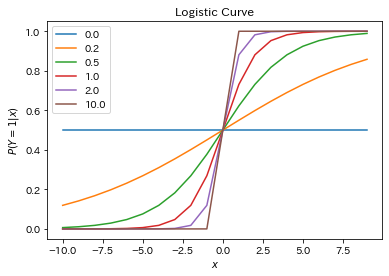

In [7]:
beta_0 = 0
beta_seq = np.array([0, 0.2, 0.5, 1, 2, 10])
m = len(beta_seq)
x = np.arange(-10, 10)
for i in range(m):
    beta = beta_seq[i]
    plt.plot(x, f(x), label=beta_seq[i])
plt.title("Logistic Curve")
plt.xlabel("$x$")
plt.ylabel("$P(Y=1|x)$")
plt.legend()

In [8]:
# Data Generation
N = 100
p = 2
X = np.random.randn(N, p)
X = np.concatenate([np.ones(N).reshape(N, 1), X], axis=1)
beta = np.random.randn(p+1)
y = np.zeros(N)
s = np.dot(X, beta)
prob = 1 / (1 + np.exp(s))
for i in range(N):
    if np.random.rand(1) > prob[i]:
        y[i] = 1
    else:
        y[i] = -1
beta

array([-1.22159862, -0.28266342, -0.86123103])

In [9]:
# Maximum Likelihood
beta = np.inf
gamma = np.random.randn(p + 1)
while np.sum((beta - gamma) ** 2) > 0.001:
    beta = gamma.copy()
    s = np.dot(X, beta)
    v = np.exp(-s * y)
    u = y * v / (1 + v)
    w = v / (1 + v)**2
    z = s + u / w
    W = np.diag(w)
    gamma = np.dot(np.linalg.inv(X.T @ W @ X), np.dot(X.T @ W, z))       ##
    print(gamma)
beta  # True value that we want to estimate

[-0.77571434 -1.00600073 -1.42686351]
[-1.49176335 -0.11551432 -0.16596346]
[-1.47683983 -0.37360996 -0.61463091]
[-1.55440605 -0.39879184 -0.64280176]
[-1.55706022 -0.40033402 -0.64462064]


array([-1.55440605, -0.39879184, -0.64280176])

In [12]:
def logistic_lasso(X, y, lam):
    p = X.shape[1]   # The # of columns of X
    beta = np.inf
    gamma = np.random.randn(p)
    while np.sum((beta - gamma)**2) > 0.001:
        beta = gamma.copy()
        s = np.dot(X, beta)
        v = np.exp(-s * y)
        u = y * v / (1 + v)
        w = v / (1 + v)**2
        z = s + u / w
        W = np.diag(w)
        gamma_0, gamma_1 = W_linear_lasso(X[:, range(1, p)], z, W, lam=lam)
        gamma = np.block([gamma_0, gamma_1]).copy()
        print(gamma)
    return gamma

In [16]:
##  From Chapter 1
def soft_th(lam, x):
    return np.sign(x) * np.maximum(np.abs(x) - lam, np.zeros(1))
def centralize(X0, y0, standardize=True):
    X = copy.copy(X0)
    y = copy.copy(y0)
    n, p = X.shape
    X_bar = np.zeros(p)                   # Mean of each column of X
    X_sd = np.zeros(p)                    # SD of each column of X
    for j in range(p):
        X_bar[j] = np.mean(X[:, j])
        X[:, j] = X[:, j] - X_bar[j]      # Centralize each column of X
        X_sd[j] = np.std(X[:, j])
        if standardize is True:
            X[:, j] = X[:, j] / X_sd[j]   # Centralize each column of X
    if np.ndim(y) == 2:
        K = y.shape[1]
        y_bar = np.zeros(K)               # Mean of y
        for k in range(K):
            y_bar[k] = np.mean(y[:, k])
            y[:, k] = y[:, k] - y_bar[k]  # Centralize y
    else:                                 # when y is a vector
        y_bar = np.mean(y)
        y = y - y_bar
    return X, y, X_bar, X_sd, y_bar
def linear_lasso(X, y, lam=0, beta=None):
    n, p = X.shape
    if beta is None:
        beta = np.zeros(p)
    X, y, X_bar, X_sd, y_bar = centralize(X, y)   # Centralize
    eps = 1
    beta_old = copy.copy(beta)
    while eps > 0.00001:    # Wait the convergence of this loop
        for j in range(p):
            r = y
            for k in range(p):
                if j != k:
                    r = r - X[:, k] * beta[k]
            z = (np.dot(r, X[:, j]) / n) / (np.dot(X[:, j], X[:, j]) / n)
            beta[j] = soft_th(lam, z)
        eps = np.linalg.norm(beta - beta_old, 2)
        beta_old = copy.copy(beta)
    beta = beta / X_sd   # Recover the coefficients to before normalization
    beta_0 = y_bar - np.dot(X_bar, beta)
    return beta, beta_0

In [17]:
N = 100
p = 2
X = np.random.randn(N, p)
X = np.concatenate([np.ones(N).reshape(N, 1), X], axis=1)
beta = np.random.randn(p + 1)
print("beta ="); print(beta)
y = np.ones(N)
s = np.dot(X, beta)
prob = 1 / (1 + np.exp(s))
for i in range(N):
    if np.random.rand(1) > prob[i]:
        y[i] = 1
    else:
        y[i] = -1
logistic_lasso(X, y, 0)

beta =
[ 1.57392404  1.39208373 -0.96330724]
[ 1.34242918  0.50054137 -0.7428512 ]
[ 1.44506053  1.27924057 -1.13889946]
[ 1.57498333  1.44973123 -1.29638992]
[ 1.58871421  1.46526941 -1.31265452]


array([ 1.58871421,  1.46526941, -1.31265452])

In [18]:
logistic_lasso(X, y, 0.1)

[ 1.15085895  0.92341001 -0.62195273]
[ 1.247316    0.94688772 -0.77020225]
[ 1.2624972   0.95711775 -0.79572359]


array([ 1.2624972 ,  0.95711775, -0.79572359])

In [19]:
logistic_lasso(X, y, 0.2)

[ 1.52012928  0.         -0.69692991]
[ 0.88221408  0.76159078 -0.35367898]
[ 1.04231912  0.55964445 -0.37924865]
[ 1.04780261  0.55482849 -0.39471363]


array([ 1.04780261,  0.55482849, -0.39471363])

In [20]:
def table_count(m, u, v):
    n = u.shape[0]
    count = np.zeros([m, m])
    for i in range(n):
        count[int(u[i]), int(v[i])] += 1
    return(count)

In [21]:
# Data Generation
N = 100
p = 2
X = np.random.randn(N, p)
X = np.concatenate([np.ones(N).reshape(N, 1), X], axis=1)
beta = np.random.randn(p+1)
y = np.zeros(N)
s = np.dot(X, beta)
prob = 1 / (1 + np.exp(s))
for i in range(N):
    if np.random.rand(1) > prob[i]:
        y[i] = 1
    else:
        y[i] = -1
print(beta)
# Parameter Estimation
beta_est = logistic_lasso(X, y, 0.1)
# Classification
for i in range(N):
    if np.random.rand(1) > prob[i]:
        y[i] = 1
    else:
        y[i] = int(-1)
z = np.sign(np.dot(X, beta_est))  # +1 and -1 when Exponent is positive and negative
table_count(2, (y+1)/2, (z+1)/2)

[-0.69526176  0.81118454  0.12185876]
[-0.59887671  0.45649027  0.        ]
[-0.52824985  0.92384003 -0.        ]
[-0.5498305   1.03492222 -0.        ]
[-0.55310105  1.05213675 -0.        ]


array([[55., 17.],
       [15., 13.]])

In [ ]:
# Linux（not available for Windows, Google Colaboratory）
import numpy as np
import matplotlib.pyplot as plt
import glmnet_python
from glmnet import glmnet
import sys
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot

In [ ]:
# Put "breastcancer.csv" in a folder of Linux.
x = np.loadtxt("breastcancer.csv", delimiter=",", skiprows=1, usecols=range(1000))
y = np.loadtxt("breastcancer.csv", delimiter=",", skiprows=1, dtype="unicode", usecols=1000)
n = len(y)
yy = np.ones(n)
for i in range(n):
    if y[i] == "control":
        yy[i] = 1
    else:
        yy[i] = -1
fit1 = cvglmnet(x=x.copy(), y=yy.copy(), ptype="deviance", family="binomial")
fit2 = cvglmnet(x=x.copy(), y=yy.copy(), ptype="class", family="binomial")
beta = cvglmnetCoef(fit1)
np.sum(beta != 0)

In [ ]:
# Make the CV graph.
fig = plt.figure()
cvglmnetPlot(fit1)
fig.savefig("img1.png")
fig2 = plt.figure()
cvglmnetPlot(fit2)
fig2.savefig("img2.png")
# Observe that "img1.png", "img2.png" have been generated in the folder in the Linux machine

# 2.3 Logistic Regression for Multiple Values

In [22]:
def multi_lasso(X, y, lam):
    n, p = X.shape
    K = len(set(y))
    beta = np.ones((K, p))
    gamma = np.zeros((K, p))
    while np.linalg.norm(beta - gamma, 2) > 0.1:
        gamma = beta.copy()
        for k in range(K):
            r = 0
            for h in range(K):
                if (k != h):
                    r = r + np.exp(np.dot(X, beta[h, :]))
            v = np.exp(np.dot(X, beta[k, :])) / r
            u = (y == k) - v / (1 + v)
            w = v / (1 + v) ** 2
            z = np.dot(X, beta[k, :]) + u / w
            beta_0, beta_1 = W_linear_lasso(X[:, range(1, p)], z, np.diag(w), lam=lam)
            beta[k, :] = np.block([beta_0, beta_1]).copy()
    for j in range(p):
        med = np.median(beta[:, j])
        for h in range(K):
            beta[h, j] = beta[h, j] - med
    return beta

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()
X = np.array(iris["data"])
y = np.array(iris["target"])
N = len(y)
X = np.concatenate([np.ones(N).reshape(N, 1), X], axis=1)
print(X.shape)
beta = multi_lasso(X, y, 0.01)
np.dot(X, beta.T)

(150, 5)


array([[ 17.0749972 ,   6.41392673, -43.4161975 ],
       [ 17.0749972 ,   6.1624002 , -40.7032929 ],
       [ 17.85013141,   5.91087366, -42.33956761],
       [ 16.29986299,   5.78511039, -40.20322342],
       [ 17.0749972 ,   6.28816347, -43.84778607],
       [ 13.99085341,   6.79121654, -40.43631166],
       [ 16.69562662,   5.78511039, -41.03797286],
       [ 16.29986299,   6.28816347, -42.05295087],
       [ 17.0749972 ,   5.53358385, -39.79602285],
       [ 16.67923356,   6.1624002 , -41.91201874],
       [ 16.29986299,   6.79121654, -43.90267832],
       [ 15.52472878,   6.03663693, -41.12129281],
       [ 17.45436777,   6.03663693, -42.09496724],
       [ 19.77977041,   5.40782058, -44.01785869],
       [ 18.62526562,   7.29426962, -48.07169845],
       [ 15.54112184,   7.16850635, -44.77469163],
       [ 17.09139026,   6.79121654, -43.52870191],
       [ 16.69562662,   6.41392673, -41.94524291],
       [ 14.37022399,   7.16850635, -41.63423817],
       [ 15.92049241,   6.41392

In [ ]:
# Run on Linux（not available for Windows, Google Colaboratory）
import numpy as np
import matplotlib.pyplot as plt
import glmnet_python
from glmnet import glmnet
import sys
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot

In [ ]:
# put "breastcancer.csv" in Linux
from sklearn.datasets import load_iris
iris = load_iris()
X = np.array(iris["data"])
y = np.array(iris["target"], dtype="float64")
cvfit3 = cvglmnet(x=X.copy(), y=y.copy(), ptype="deviance", family="multinomial")
lam_min = cvfit1["lambda_min"]
beta = cvglmnetCoef(cvfit)
print(lam_min)
print(beta)

In [ ]:
# Make CV graph
fig3 = plt.figure()
cvglmnetPlot(cvfit3)
fig3.savefig("img3.png")

In [ ]:
K = 3
p = 5
n = 150
gamma = np.zeros((K, p))
for k in range(K):
    for j in range(p):
        gamma[k, j] = np.sum(beta[k][j])
v = np.zeros(n)
for i in range(n):
    max_value = -np.inf
    for k in range(K):
        value = gamma[k, 0] + np.dot(gamma[k, range(1, p)], X[i, :])
        if value > max_value:
            v[i] = k
            max_value = value
table_count(3, y, v)

## 2.4 Poisson Regression

In [24]:
def poisson_lasso(X, y, lam):
    p = X.shape[1]   # p counts the column of all ones
    beta = np.random.randn(p)
    gamma = np.random.randn(p)
    while np.sum((beta - gamma)**2) > 0.0001:
        beta = gamma
        s = np.dot(X, beta)
        w = np.exp(s)
        u = y - w
        z = s + u / w
        gamma_0, gamma_1 = W_linear_lasso(X[:, range(1, p)], z, np.diag(w), lam)
        gamma = np.block([gamma_0, gamma_1]).copy()
        print(gamma)
    return gamma

In [27]:
N = 100    # In case lambda is too small, the ML estimate cannot be obtained.
p = 3
X = np.random.randn(N, p)
X = np.concatenate([np.ones(N).reshape(N, 1), X], axis=1)
beta = np.random.randn(p + 1)
s = np.dot(X, beta)
y = np.random.poisson(lam=np.exp(s))
print(beta)

[-0.06808696 -0.98073289  0.41729465 -0.1347939 ]


In [28]:
poisson_lasso(X, y, 2)

[ 2.24171235 -0.0267108   0.         -0.        ]
[ 1.42474052 -0.          0.         -0.        ]
[ 0.83611672 -0.          0.         -0.        ]
[ 0.57721402 -0.          0.         -0.        ]
[ 0.53731132 -0.          0.         -0.        ]
[ 0.5364937 -0.         0.        -0.       ]


array([ 0.5364937, -0.       ,  0.       , -0.       ])

In [ ]:
# run on Linux （not on Windows, Google Colaboratory）
import numpy as np
import matplotlib.pyplot as plt
import glmnet_python
from glmnet import glmnet
import sys
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot

In [ ]:
df = np.loadtxt("giants_2019.txt", delimiter="\t")
index = list(set(range(9)) - {1, 2})
X = np.array(df[:, index])
y = np.array(df[:, 1])
cvfit = cvglmnet(x=X.copy(), y=y.copy(), family="poisson")
cvglmnetCoef(cvfit)

## 2.5 Survival Analysis

In [29]:
import pandas as pd
df = pd.read_csv("kidney.csv")
df.drop(df.columns[0], axis=1, inplace=True)
df

,time,status,age,sex,disease,frail
0,8,1,28,1,Other,2.3
1,16,1,28,1,Other,2.3
2,23,1,48,2,GN,1.9
3,13,0,48,2,GN,1.9
4,22,1,32,1,Other,1.2
...,...,...,...,...,...,...
71,16,0,42,2,Other,0.7
72,6,0,52,2,PKD,2.1
73,78,1,52,2,PKD,2.1
74,63,1,60,1,PKD,1.2


In [30]:
def Surv(y, delta):
    n = len(y)
    z = []
    for i in range(n):
        if delta[i] == 0:
            z.append(str(y[i]) + "+")
        else:
            z.append(str(y[i]))
    return z

In [31]:
y = df["time"]
delta = df["status"]
print(Surv(y, delta))

['8', '16', '23', '13+', '22', '28', '447', '318', '30', '12', '24', '245', '7', '9', '511', '30', '53', '196', '15', '154', '7', '333', '141', '8+', '96', '38', '149+', '70+', '536', '25+', '17', '4+', '185', '177', '292', '114', '22+', '159+', '15', '108+', '152', '562', '402', '24+', '13', '66', '39', '46+', '12', '40', '113+', '201', '132', '156', '34', '30', '2', '25', '130', '26', '27', '58', '5+', '43', '152', '30', '190', '5+', '119', '8', '54+', '16+', '6+', '78', '63', '8+']


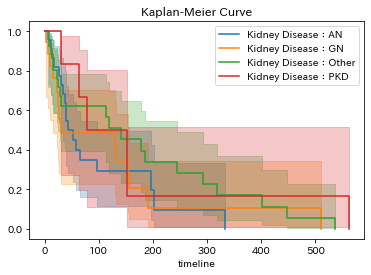

In [32]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
ax = None
for name, group in df.groupby("disease"):
    kmf.fit(group["time"], event_observed=group["status"],
            label="Kidney Disease：" + str(name))
    if ax is None:
        ax = kmf.plot()
    else:
        ax = kmf.plot(ax=ax)
plt.title("Kaplan-Meier Curve")
plt.show()

In [33]:
def cox_lasso(X, y, delta, lam):
    delta[0] = 1
    n = len(y)
    w = np.zeros(n)
    u = np.zeros(n)
    pi = np.zeros((n, n))
    beta = np.random.randn(p)
    gamma = np.zeros(p)
    while np.sum((beta - gamma)**2) > 10**(-4):
        beta = gamma.copy()
        s = np.dot(X, beta)
        v = np.exp(s)
        for i in range(n):
            for j in range(n):
                pi[i, j] = v[i] / np.sum(v[j:n])
        for i in range(n):
            u[i] = delta[i]
            w[i] = 0
            for j in range(i+1):
                if delta[j] == 1:
                    u[i] = u[i] - pi[i, j]
                    w[i] = w[i] + pi[i, j] * (1 - pi[i, j])
            z = s + u / w
        W = np.diag(w)
        print(gamma)
        gamma0, gamma = W_linear_lasso(X, z, W, lam=lam)
    return gamma

In [34]:
df = df.sort_values("time")
y = df["time"]
p = 4
delta = df["status"]
X = df[["age", "sex", "disease", "frail"]].copy()
size_mapping = {"GN": 1, "AN": 2, "PKD": 3, "Other": 0}
X["disease"] = df["disease"].map(size_mapping)
X = np.array(X); y = np.array(y); delta = np.array(delta)
cox_lasso(X, y, delta, 0)

[0. 0. 0. 0.]
[ 0.010432   -1.71518832 -0.37390345  1.33716878]
[ 0.01478213 -1.64157246 -0.40155686  1.37863492]
[ 0.01616734 -1.62043703 -0.41091684  1.39632499]
[ 0.01661315 -1.61578004 -0.4142613   1.40464894]


array([ 0.01676301, -1.61572413, -0.41563326,  1.40892236])

In [35]:
cox_lasso(X, y, delta, 0.1)

[0. 0. 0. 0.]
[ 0.         -1.00021319 -0.07583775  0.99765711]
[ 0.         -0.93830037 -0.0471629   0.96658923]
[ 0.         -0.91900008 -0.04067863  0.9537008 ]


array([ 0.        , -0.91340382, -0.03929811,  0.94878576])

In [36]:
cox_lasso(X, y, delta, 0.2)

[0. 0. 0. 0.]
[ 0.         -0.51061984 -0.          0.72069946]
[ 0.         -0.48841277 -0.          0.68736493]


array([ 0.        , -0.48432671, -0.        ,  0.67844288])

In [ ]:
# For Linux （Not run for Windows, Google Colaboratory）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glmnet_python
from glmnet import glmnet
from glmnetCoef import glmnetCoef
import sys
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot
import os
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from lifelines import KaplanMeierFitter

In [ ]:
# For Linux （Not run for Windows, Google Colaboratory）
# The best coefficients （29 out of 7339 are nonzero）
base = importr("base")
base.load("LymphomaData.rda")
w = robjects.globalenv["patient.data"]
X = np.array(w[0]).T
y = np.array(w[1])
delta = np.array(w[2])
w = np.concatenate([y.reshape(240, 1), delta.reshape(240, 1)], axis=1)
fit = glmnet(x=X.copy(), y=w.copy(), family="cox")
beta = glmnetCoef(fit, s=np.float64([0.119787]))
print(np.sum(beta != 0))

In [ ]:
# Run on Linux （Not run on Windows, Google Colaboratory）
# Kaplan-Meier Curve
z = np.sign(np.dot(X, beta))
df2 = pd.DataFrame(np.concatenate([y.reshape(240, 1), delta.reshape(240, 1), z], axis=1))
df2.columns = ["time", "status", "sign"]
fig = plt.figure()
kmf = KaplanMeierFitter()
ax = None
for name, group in df2.groupby("sign"):
    kmf.fit(group["time"], event_observed=group["status"],
            label="z = " + str(name))
    if ax is None:
        ax = kmf.plot()
    else:
        ax = kmf.plot(ax=ax)

In [ ]:
plt.title("Kaplan-Meier Curve")
fig.savefig("img7.png")